# Cf nubar with USU

Load the required modules, functions from gmapy
and widely used data science packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gmapy.mappings.tf.compound_map_tf \
    import CompoundMap as CompoundMapTF
from gmapy.tf_uq.custom_distributions import (
    MultivariateNormalLikelihoodWithCovParams,
)
from gmapy.tf_uq.inference import determine_MAP_estimate
from gmapy.tf_uq.inference import generate_MCMC_chain

2025-01-30 14:54:05.054783: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 14:54:05.055120: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 14:54:05.057773: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-30 14:54:05.085660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 14:54:05.549330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Next we define the theoretical quantities we want to estimate. Here it is a single one: Cf nubar

In [2]:
priortable = pd.DataFrame.from_records([
    {'NODE': 'xsid_1', 'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'PRIOR': 1.0, 'UNC': 1e4},
])
priorcov = np.diag(np.square(priortable.UNC))  # not used

Next we define the experimental quantities. Here they are only nubar measurements. Uncertainty is given absolute

In [3]:
exptable = pd.DataFrame.from_records([
    {'NODE': 'exp_1',  'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.755, 'UNC': 1.618e-2 },
    {'NODE': 'exp_2',  'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.783, 'UNC': 8.361e-3 },
    {'NODE': 'exp_3',  'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.777, 'UNC': 3.165e-2 },
    {'NODE': 'exp_4',  'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.791, 'UNC': 4.041e-2 },
    {'NODE': 'exp_5',  'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.819, 'UNC': 3.945e-2 },
    {'NODE': 'exp_6',  'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.755, 'UNC': 1.126e-2 },
    {'NODE': 'exp_7',  'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.730, 'UNC': 3.006e-2 },
    {'NODE': 'exp_8',  'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.740, 'UNC': 1.638e-2 },
    {'NODE': 'exp_9',  'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.762, 'UNC': 1.817e-2 },
    {'NODE': 'exp_10', 'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.768, 'UNC': 1.142e-2 },
    {'NODE': 'exp_11', 'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.764, 'UNC': 2.676e-2 },
    {'NODE': 'exp_12', 'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.747, 'UNC': 2.174e-2 },
    {'NODE': 'exp_13', 'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.751, 'UNC': 1.737e-2 },
    {'NODE': 'exp_14', 'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.753, 'UNC': 1.839e-2 },
    {'NODE': 'exp_15', 'REAC': 'MT:1-R1:1', 'ENERGY': 1.0, 'DATA': 3.783, 'UNC': 2.871e-2 },
])
expcov = np.diag(np.square(exptable.UNC / exptable.DATA))

We define variables that are convenient to be used later, such as number of physical quantities to estimate `num_params` and the number of unknown parameters in the covariance matrix. Here we are using one shared usu component.

In [4]:
# some convenient shortcuts
priorvals = priortable.PRIOR.to_numpy()
expvals = exptable.DATA.to_numpy()

num_params = len(priorvals)
num_covpars = 1 
num_allpars = num_params + num_covpars

We combine the prior of physical quantities with the unknown USU uncertainty component

In [5]:
covpars = np.full(num_covpars, 0.)
ext_priorvals = tf.concat([priorvals, covpars], axis=0)

# prepare extended 

The prior table `priortable` and the experimental table `exptable` contain all the information to create a `mapping` object that knows how to propagate the values associated with the physical quantities to the ones stored in `exptable`

In [6]:
compmap = CompoundMapTF((priortable, exptable), reduce=True)

Next, we define a function that returns a `LinearOperator` objects (in principle just a matrix) to represent the experimental covariance matrix that includes the USU component. The value of the USU component is passed to this function.

In [7]:
def like_cov_fun(usu_unc):
    expcov_tf = tf.constant(expcov)
    usu_var = tf.square(usu_unc)
    size = tf.shape(expcov_tf)[0] 
    repeated_usu_var = tf.repeat(usu_var, size) 
    usu_cov = tf.linalg.diag(repeated_usu_var)
    # calculate total covariance matrix
    expcov_with_usu = tf.linalg.LinearOperatorFullMatrix(expcov_tf + usu_cov)
    return expcov_with_usu


# REMOVE: testing
usu_uncs = tf.constant(1, dtype=tf.float64)
like_cov_fun(usu_uncs)

TODO

In [8]:
covpars = np.full(num_covpars, 1.)
ext_priorvals = tf.concat([priorvals, covpars], axis=0)

The `compmap` objects has two methods `propagate` and `jacobian` that are needed for Maximum Likelihood Estimation and also the MCMC sampling. We can use tensorflow functionality to speed up their calculation (by compilation)

In [9]:
propfun = tf.function(compmap.propagate)
jacfun = tf.function(compmap.jacobian)

We use these two functions and the experimental data with their covariance matrix to define the multivariate normal distribution

In [10]:
likelihood = MultivariateNormalLikelihoodWithCovParams(
    num_params, num_covpars,
    propfun, jacfun,
    expvals, like_cov_fun,
    approximate_hessian=True, relative=True
)

In principle, we want to sample from the posterior distribution, which is the product of prior and likelihood. However, here we assume for simplicity a flat prior so the posterior is proportional to the likelihood.

In [11]:
post = likelihood 

For the Maximum Likelihood Estimation (MLE) we need the gradient and the Hessian of the objective function is also helpful. We use again tensorflow to speed up the computation of these quantities.

In [12]:
neg_log_prob_and_gradient = tf.function(post.neg_log_prob_and_gradient)
neg_log_post_hessian = post.neg_log_prob_hessian

Now we can do the MLE. The following function is in principle a wrapper around the BFGS optimization algorithm (implemented in `Tensorflow Probability`.

In [13]:
optres = determine_MAP_estimate(
    ext_priorvals, neg_log_prob_and_gradient,
    neg_log_post_hessian, max_inner_iters=500, max_outer_iters=50, nugget=1e-3,
    ret_optres=True, must_converge=True
)

#  outer iteration 1
-- running inner iteration with 500 iterations


2025-01-30 14:54:07.682999: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Inner iterations: 22


The optimization result is available in `optres.position`. We also set the seed for reproducible MCMC chain.

In [14]:
# set seed for MCMC
tf.random.set_seed(42)
# define essential input quantities for MCMC
optvals = optres.position

Now we are running MCMC using Hamiltonian Monte Carlo provided by `Tensorflow Probability` package. The following function is a part of `gmapy` that wraps around the tensorflow probability function.

In [15]:
import time
s1 = time.time()
chain, tracing_info = generate_MCMC_chain(
    optvals, post.log_prob, post.neg_log_prob_hessian,
    nugget=1e-8, step_size=1, num_burnin_steps=int(1e3),
    num_results=int(1e4), num_leapfrog_steps=1
)
s2 = time.time()
print(s2-s1)

37.974676847457886


The full chain is stored in `chain` for all two variables (nubar and usu uncertainty). We extract this chains into separate variables for convenience.

In [16]:
import matplotlib.pyplot as plt

chain_np = chain.numpy()

nubar_chain = chain_np[:,0]
usu_chain = np.abs(chain[:, 1])

We perform some diagnostics to see how many samples we have obtained effectively for nubar and usu uncertainty.

In [17]:
from gmapy.mcmc_inference import compute_effective_sample_size
print(compute_effective_sample_size(nubar_chain))
print(compute_effective_sample_size(usu_chain))

21370.75096673589
4125.909956404004


(array([2.000e+00, 1.000e+00, 3.000e+00, 1.100e+01, 2.900e+01, 3.000e+01,
        7.300e+01, 6.900e+01, 1.790e+02, 2.830e+02, 3.960e+02, 6.470e+02,
        9.490e+02, 1.081e+03, 1.248e+03, 1.323e+03, 1.108e+03, 9.230e+02,
        6.660e+02, 4.480e+02, 2.560e+02, 1.430e+02, 6.700e+01, 2.500e+01,
        1.700e+01, 1.300e+01, 7.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([3.7380486 , 3.73973408, 3.74141956, 3.74310504, 3.74479052,
        3.746476  , 3.74816148, 3.74984696, 3.75153244, 3.75321792,
        3.75490339, 3.75658887, 3.75827435, 3.75995983, 3.76164531,
        3.76333079, 3.76501627, 3.76670175, 3.76838723, 3.7700727 ,
        3.77175818, 3.77344366, 3.77512914, 3.77681462, 3.7785001 ,
        3.78018558, 3.78187106, 3.78355654, 3.78524202, 3.78692749,
        3.78861297]),
 <BarContainer object of 30 artists>)

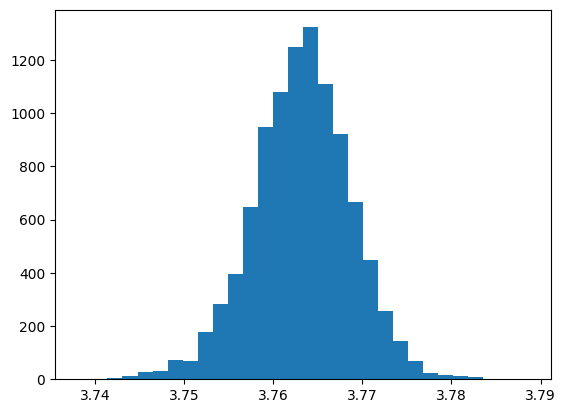

In [18]:
plt.hist(nubar_chain, bins=30)

(array([6.740e+02, 7.410e+02, 9.220e+02, 1.049e+03, 1.212e+03, 1.070e+03,
        1.007e+03, 8.470e+02, 6.870e+02, 4.840e+02, 3.900e+02, 2.620e+02,
        2.450e+02, 1.430e+02, 7.500e+01, 5.500e+01, 4.600e+01, 2.800e+01,
        2.600e+01, 1.500e+01, 5.000e+00, 8.000e+00, 2.000e+00, 1.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([6.86502565e-07, 4.41913412e-04, 8.83140321e-04, 1.32436723e-03,
        1.76559414e-03, 2.20682105e-03, 2.64804796e-03, 3.08927487e-03,
        3.53050178e-03, 3.97172869e-03, 4.41295559e-03, 4.85418250e-03,
        5.29540941e-03, 5.73663632e-03, 6.17786323e-03, 6.61909014e-03,
        7.06031705e-03, 7.50154396e-03, 7.94277087e-03, 8.38399778e-03,
        8.82522469e-03, 9.26645160e-03, 9.70767851e-03, 1.01489054e-02,
        1.05901323e-02, 1.10313592e-02, 1.14725861e-02, 1.19138131e-02,
        1.23550400e-02, 1.27962669e-02, 1.32374938e-02]),
 <BarContainer object of 30 artists>)

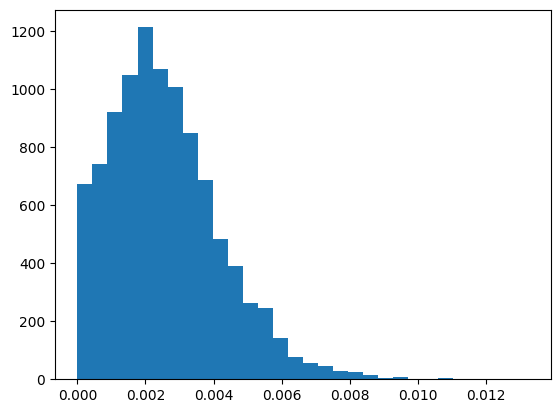

In [19]:
plt.hist(usu_chain, bins=30)

In [20]:
nubar_eval = np.mean(nubar_chain)
nubar_unc = np.std(nubar_chain)
print(nubar_eval)
print(nubar_unc / nubar_eval)

3.7631865725354983
0.001467197537705996


In [21]:
usu_eval = np.mean(usu_chain)
usu_unc = np.std(usu_chain)
print(usu_eval)
print(usu_unc)

0.0025865287450289333
0.0016202405961243751
